<a href="https://colab.research.google.com/github/Jojocko/NLP-projects-/blob/main/Supply_chain_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

df = pd.read_csv('/content/drive/My Drive/Datasets NLP/dataset_supplychain.csv')

Mounted at /content/drive


In [2]:
df = df.drop(['client', 'langage', 'reponse'], axis=1)
df.rename(columns={'Sentiment': 'sentiment', 'Commentaire': 'commentaire'}, inplace=True)
df['sentiment'] = df['sentiment'].replace({'__label__POSITIVE': 'positif', '__label__NEGATIVE': 'negatif', '__label__NEUTRAL': 'neutre'})
df['date'] = df['date'].fillna(method="ffill")
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year # pour une visualisation de l'évolution chronologique plus claire

In [3]:
df_paires = pd.read_csv('/content/drive/My Drive/Datasets NLP/paires_commentaires.csv')

In [4]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('french'))

jugement = {'très', 'extrêmement', 'particulièrement', 'exceptionnellement','tout à fait', 'absolument', 'complètement', 'entièrement', 'parfaitement', 'profondément', 'hautement', 'tout', 'plutôt', 'assez', 'bien', 'bon','vraiment', 'totalement', 'énormément', 'peu', 'moins'}
satisfaction = {'satisfait', 'content', 'heureux', 'ravi', 'enchanté', 'comblé', 'agréable', 'plaisant', 'positif', 'excellent', 'remarquable', 'exceptionnel', 'superbe', 'admirable', 'réjoui', 'gratifiant', 'récompensant', 'conquis', 'impressionné', 'élogieux'}
insatisfaction = {'insatisfait', 'mécontent', 'déçu', 'frustré', 'contrarié', 'désappointé', 'inacceptable', 'problématique', 'inadmissible', 'déplorable', 'lamentable', 'irrité', 'en colère', 'révolté', 'amère', 'négatif', 'critique', 'malheureux', 'peu convaincu', 'regrettable'}
company = {'Fnac', 'fnac', 'Amazon', 'amazon', 'CDiscount', 'cdiscount'}

stop_words.update(jugement, satisfaction, insatisfaction, company)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
# Traitement des données

import re
import unicodedata
from nltk.tokenize import word_tokenize

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!]+", " ", w)
    w = re.sub(r'\b\w{0,2}\b', '', w)

    mots = word_tokenize(w.strip())
    mots = [mot for mot in mots if mot not in stop_words]
    return ' '.join(mots).strip()

df.cleaned_lemma = df.cleaned_lemma.apply(lambda x :preprocess_sentence(x))

In [6]:
# Prétraitement ET lemmatisation pour df_paires

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

lemmatizer = WordNetLemmatizer()

def lemmatisation(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def preprocess_and_lemmatize(sentence):
    sentence = unicode_to_ascii(sentence.lower().strip())
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!]+", " ", sentence)
    sentence = re.sub(r'\b\w{0,2}\b', '', sentence)

    mots = word_tokenize(sentence.strip())
    mots_tagged = pos_tag(mots)

    lemmatizer = WordNetLemmatizer()
    mots_lemmatises = [lemmatizer.lemmatize(mot, lemmatisation(tag)) for mot, tag in mots_tagged]
    mots_lemmatises = [mot for mot in mots_lemmatises if mot not in stop_words]

    return ' '.join(mots_lemmatises).strip()

df_paires['Commentaire A'] = df_paires['Commentaire A'].apply(preprocess_and_lemmatize)
df_paires['Commentaire B'] = df_paires['Commentaire B'].apply(preprocess_and_lemmatize)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# Calcul de la distance sémantique des paires de comm (100 paires)

!pip install sentence-transformers
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

import numpy as np

model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2') # spécialisé dans la génération d'embeddings + fr

embeddings_A = model.encode(df_paires['Commentaire A'].tolist(), convert_to_tensor=True) # conversion en tensor 2D pour calculer la cosine similarity
embeddings_B = model.encode(df_paires['Commentaire B'].tolist(), convert_to_tensor=True)

embeddings_A_cpu = [embedding.cpu().numpy() for embedding in embeddings_A]
embeddings_B_cpu = [embedding.cpu().numpy() for embedding in embeddings_B]

similarities = [cosine_similarity([embeddings_A_cpu[i]], [embeddings_B_cpu[i]])[0][0] for i in range(len(embeddings_A_cpu))]

df_paires['Distance sémantique'] = similarities

print(df_paires.head()) # enlever print la prochaine fois pour un meilleur affichage


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 77.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.12k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

                                             Commentaire A  \
0                          site tellement lent frustrant .   
1                          site tellement lent frustrant .   
2                          site tellement lent frustrant .   
3                          site tellement lent frustrant .   
4  mal trouver produits voulais moteur recherche mauvais .   

                                                   Commentaire B  \
0        mal trouver produits voulais moteur recherche mauvais .   
1                 site plante juste moment finalisais commande .   
2                   interface utilisateur intuitive perds temp .   
3  site pa adapte mobile impossible commander depuis telephone .   
4                 site plante juste moment finalisais commande .   

   Distance sémantique  
0             0.512581  
1             0.299672  
2             0.437125  
3             0.208907  
4             0.171799  


In [8]:
# Finetuning du transformer

from sentence_transformers import InputExample, losses # encapsule une paire d'entrées textuelles et, éventuellement, une étiquette (label) associée à cette paire.
from torch.utils.data import DataLoader # encapsule des données (paires + distances sémantiques) +  batching, mélange des données

paires = [InputExample(texts=[row['Commentaire A'], row['Commentaire B']], label=float(row['Distance sémantique'])) for index, row in df_paires.iterrows()]

train_set = DataLoader(paires, shuffle=True, batch_size=200)

train_loss = losses.CosineSimilarityLoss(model=model)

model.fit(train_objectives=[(train_set, train_loss)], epochs=10, warmup_steps=100) # warmup = augmentation du learning_rate pour stabilier l'entraînement au début



Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
# Clustering

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min

embeddings_negatif = model.encode(df[df['sentiment'] == 'negatif']['cleaned_lemma'].tolist(), show_progress_bar=True)

# Normalisatin
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings_negatif)

kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(embeddings_scaled)



Batches:   0%|          | 0/868 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [25]:

df_negatifs['cluster'] = clusters

df_negatifs = df_negatifs.reset_index(drop=True)

# Afficher 5 commentaires pour chaque cluster pour vérifier la qualité des clusters
for i in range(10):
    print(f"Cluster {i}:")
    commentaires_cluster = df_negatifs[df_negatifs['cluster'] == i]['cleaned_lemma']
    for commentaire in commentaires_cluster.head(5):
        print(commentaire)
    print("---------\n")


Cluster 0:
disque ssd sandisk vendre garantie tomber panne ecrire renvoyer disque dur constructeur sandisk indique disque dur reparable confirmer devoir obtenir remboursement aupres vendeur conforme legislation francaise . refuser remboursement avoir devoir renvoyer disque dur rembourser . . . moque client
commande produit tupperware produit casse garantie fournisseur repondre relance reponse dernier pouvoir rien faire essayer appeler fabricant tuperware . vendre assumer rien derriere
commander cheminee bio ethanol produit apparemment servir jointure reservoir defectueux trace outil precedent montage presenter soudure noircir resoudage visible agir cheminee produit dangereux mentir premier jour dire produit rentraire garantie etre rembourser semaine bout mois prevenir mail finalement non falloir debrouiller vendeur dernier echange etre enregistrer juger odieux traite . produit rester servir rappel tenter faire achat . eviter achat necessiter securite particulier . aucun verification se

In [34]:

themes = {
    0: 'Problèmes de garantie et responsabilité du Vendeur',
    1: 'Problèmes de satisfaction des réclamations',
    2: 'Livraisons manquées et accusations de falsification',
    3: 'Gestion défaillante des colis perdus ou non livrés',
    4: 'Problèmes de remboursement',
    5: 'Commandes endommagées et retours compliqués',
    6: 'Frustrations concernant les abonnements et les prix',
    7: 'Censure d\'Avis',
    8: 'Politiques de retour restrictives',
    9: 'Délais de livraison non respectées'
}
pd.set_option('display.max_colwidth', 500)
df_negatifs = df_negatifs.drop(['cleaned_words', 'date'], axis=1)
df_negatifs.head(10)



,commentaire,star,source,company,cleaned_lemma,sentiment,year,theme,themes,cluster
0,"Colis commandé mardi 28 fevrier 23 , livraison le jeudi 02 mars 23 produit non recu au 7 mars 23Au prix du colis, amazon des incapables et chronopost pareilService client qui veule que je patiente une journée de plusLe colis est introuvable et meme chronopost renvoie la balle a amazonAmazon veut pas me renvoyé un autre article alors que ca fait une semaine que j'attend ce colis",1,TrustPilot,Amazon,colis commander mardi fevrier livraison jeudi mars produit non recu mars prix colis incapable chronopost pareilservic client veule patient journee plusle colis introuvable chronopost renvoyer balle amazonamazon vouloir renvoyer article semaine attendre colis,negatif,2023,Gestion défaillante des colis perdus ou non livrés,NA,3
1,Amazon avec sa politique de retour est la pire que j ai vu contrairement a d autre site marchand.Montre défectueuse rendu il y a 10 jours et toujours pas de remboursement ce sont des méthodes de voleurs et de voyous et au téléphone il n y a que des incompétents et personne n a la même version de jours de retourAmazon c est a fuir dernière fois que je commande chez eux la concurrence est plus professionnelle.,1,TrustPilot,Amazon,politique pire contrairement site marchand . montr defectueux rendre jour remboursement methode voleur voyou telephone incompetent version jour retouramazon fuir dernier fois commande concurrence professionnel,negatif,2023,Politiques de retour restrictives,NA,8
2,"Nul, preleve une commande que je n'ai jamais reçu et le service client laisse des blancs jusqu'à ce qu'on raccroche et ça sur plusieurs appel. Donc amazone ma volé Dernière commande pour moi passé chez eux, ça m'apprendras à vouloir acheter chez les americains",1,TrustPilot,Amazon,prelev commande jamais recevoir service client laisse blanc jusque raccrocher appel amazone voler dernier commande passer apprendre vouloir acheter americain,negatif,2023,Problèmes de remboursement,NA,4
3,Colis soit disant livré mais jamais reçu donc perdu non remboursé et falsification du bon de livraison soit disant signé par mes soins (Signature en majuscule) MDR je ne signe jamais de documents en majuscule ils moquent de leurs clients je vais résilier mon aboment Amazon Prime et en finir avec eux,1,TrustPilot,Amazon,colis dire livrer jamais recevoir perdre non rembourser falsification livraison dire signer soin signature majuscule mdr signe jamais document majuscule moquer client resilier aboment prime finir,negatif,2023,Livraisons manquées et accusations de falsification,NA,2
4,"D'habitude, je jure par Amazon. J'ai aussi un compte Business et j'ai Prime depuis presque son lancement. Mais, j'ai acheté des enceintes bluetooth et alors qu'ils étaient toujours sous garantie j'ai fait la demande de remplacement parce ce qu'ils saturées et celle de droite et très faible par rapport de celle de gauche. Mais, ils étaient en rupture de stock. Amazon m'a dit qu'il les remplacerai lorsque qu'ils y arriver. Alors, j'ai patienté. Maintenant hors garantie, Amazon ne répond même ...",1,TrustPilot,Amazon,habitude jurer compte busines prime presque lancement acheter enceinte bluetooth garantie demande remplacement saturer droite faible rapport gauche rupture stock remplacer arriver patienter garantie repondre message etre prevenir,negatif,2023,Politiques de retour restrictives,NA,8
5,Quand tu commandes 1 gros objet chez Amazon le livreur ne vient jamais à la date indiqué c est franchement pénible et desagreable faudrait peut être pensé à changé vos service de livraison pour l électroménager etc..,1,TrustPilot,Amazon,commande gros objet livreur venir jamais date indiquer franchement penible desagreabl falloir penser changer service livraison electromenager . .,negatif,2023,Gestion défaillante des colis perdus ou non livrés,NA,3
6,"Mon disque SSD SANDISK vendu par Amazon et sous garantie est tombé en panne. Amazon m'écrit de renvoyer le disque dur chez le constructeur, ce que je

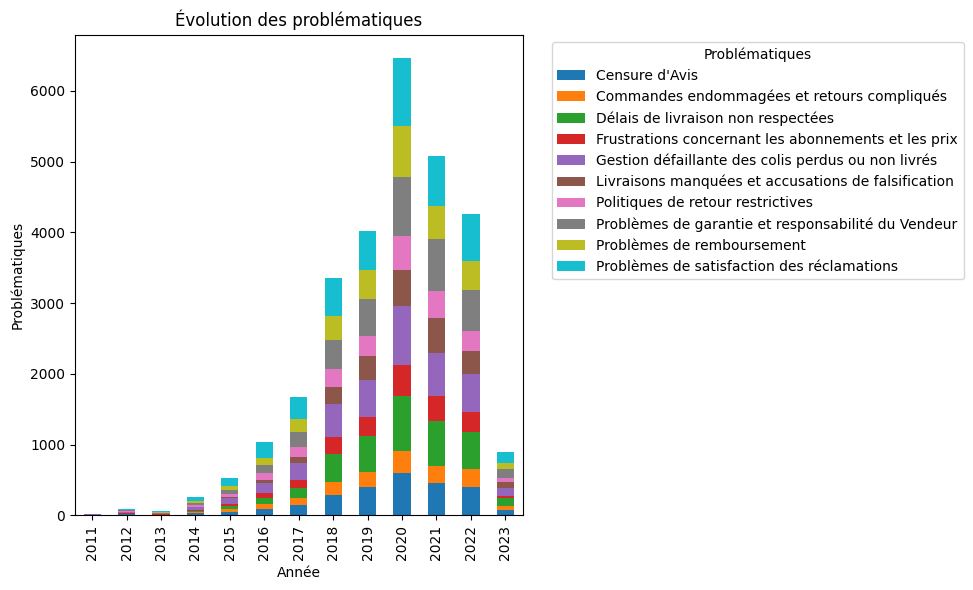

In [37]:
import matplotlib.pyplot as plt

themes_evo = df_negatifs.groupby(['year', 'theme']).size().unstack(fill_value=0)

themes_evo.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Évolution des problématiques')
plt.xlabel('Année')
plt.ylabel('Problématiques')
plt.legend(title='Problématiques', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



In [39]:
themes_company = df_negatifs.groupby(['company', 'theme']).size().unstack(fill_value=0)

print(themes_company)

theme      Censure d'Avis  Commandes endommagées et retours compliqués  \
company                                                                  
Amazon                504                                          291   
CDiscount            1658                                          910   
Fnac                  414                                          311   

theme      Délais de livraison non respectées  \
company                                         
Amazon                                    827   
CDiscount                                1998   
Fnac                                      414   

theme      Frustrations concernant les abonnements et les prix  \
company                                                          
Amazon                                                     419   
CDiscount                                                 1156   
Fnac                                                       271   

theme      Gestion défaillante des colis perdus ou n